# Visualizing the results of schedulers simulation

## Define needed functions and variables

In [1]:
import matplotlib.pyplot as plt
import sys
import json
import numpy as np
import numpy.random as random
import itertools
sys.path.append('../')  # Include parent directory in module search
sys.path.append('../../')
from schedule_simulator_core.core import Distribution
from schedule_simulator_core.simulation_presets import GpuNetworkSim
from schedule_simulator_core.schedulers import FIFOScheduler, TopologicalPriorityScheduler
from schedule_simulator_core.DAGs import serialize_dag, deserialize_dag, HomogeneousLinearDAG, \
LinearDag, LayerFactory
from model_extraction.keras_model_extractor import apply_timing_profile_to_dag, keras_model_to_DAG

#### Define schedulers

In [2]:
schedulers = [FIFOScheduler(), TopologicalPriorityScheduler(preemptive=False),
              TopologicalPriorityScheduler(preemptive=True)]

#### Define custom metrics

In [3]:
def comp_to_comm_ratio(results):
    """
    The total computational units executed / total communication units executed in all of the simulation.
    This is dependent on the dag as well as the number of batches.
    It is also dependent on the rates however we are making them a constant 1 for now
    """
    return list((np.array(results["comp_units.sum"]) * np.array(results["batch_size"]))
           / np.array(results["comm_units.sum"]))

def normalize_over(results, stat_to_normalize, grouping_stat, reference_grouping_stat_value, reverse=False):
    grouping_stat_indices = dict()
    for i, grouping_stat_value in enumerate(results[grouping_stat]):
        if grouping_stat_value in grouping_stat_indices:
            grouping_stat_indices[grouping_stat_value].append(i)
        else:
            grouping_stat_indices[grouping_stat_value] = [i]
    reference_indices = grouping_stat_indices[reference_grouping_stat_value]
    normalized_stat = [0 for _ in range(len(results[stat_to_normalize]))]
    for group_indices in grouping_stat_indices.values():
        for i, ii in enumerate(group_indices):
            if reverse:
                normalized_stat[ii] = results[stat_to_normalize][reference_indices[i]] / results[stat_to_normalize][ii]
            else:
                normalized_stat[ii] = results[stat_to_normalize][ii] / results[stat_to_normalize][reference_indices[i]]
    return normalized_stat

def network_scheduler_speedup_over_fifo(results):
    """
    Total time of fifo scheduler / total time of other scheduler
    """
    return normalize_over(results, "total_time_steps", "network_scheduler", "FIFOScheduler", reverse=True)

def format_variable(results, variable_name, format_str):
    formatted_variable = list()
    for value in results[variable_name]:
        formatted_variable.append(format_str.format(value))
    return formatted_variable

#### Visualization function

In [6]:
from schedule_simulator_core.utils import trim
def line_plot_grid(results, x, y, line_variable=None, row_variable=None, column_variable=None,
                   annotation_variable=None, annotation_only_for_line_groups=None, annotation_step=1,
                   title=None, save=False, subplot_size=None, label_length=20):
    """
    This method helps visualize up to 6 variables at once using a simple grid of line_plots.
    :param results: The simulation group results dictionary. Should be in the format of
    dict(key=variable_name, value=list_of_variable_values_in_all_simulations)
    :param x: the variable name to represent on the x axis
    :param y: the variable name to represent on the y axis
    :param annotation_variable: The variable name to annotate the x,y points with
    :param line_variable: The variable name to use to differentiate between different lines with
    or None to plot all data using one line. Should be used with discrete variables
    :param row_variable: The variable name to use to differentiate between different subplots in a row
    or None to plot all data using one row. Should be used with discrete variables
    :param column_variable: The variable name to use to differentiate between different subplots in a column
    or None to plot all data using one column. Should be used with discrete variables
    Basically the line,row and column variables are used to create groups of data which is why they should be
    discrete. There is no current support for grouping continuous data so if they are passed a continues
    variable, each value will be treated as its own group. The three variables can also be passed a tuple
    (variable_name, [list_of_values]) to only plot specific groups or specific values of that variable.
    :param annotation_only_for_line_values: A list of the line groups that we should annotate. If set to None
    then all line groups will be annotated
    :param annotation_step: Should we annotate each xy point? or should we skip some?
    :param title: The title of the graph displayed above
    :param save: Whether we should save this plot to a file or not
    :param subplot_size: The size in (width, height) of a single subplot (cell) in the grid
    """
    group_variables = dict(r=row_variable, c=column_variable, l=line_variable)
    groups = dict()
    # Add prespecified groups if they exist
    group_variables_prespecified_groups = dict()
    for key,value in group_variables.items():
        if isinstance(value, tuple):
            # Did we get a tuple with an already specified list of groups ?
            groups[key] = tuple(value[1])
            group_variables[key] = value[0]
    # Generate variable groups if they haven't already been specified
    for key,value in group_variables.items():
        # If key is already in groups that means a prespecified group was passed no need to generate
        if key in groups:
            continue
        # If value is None then we do not want to generate groups for this variable
        if value is None:
            groups[key] = (None,)
            continue
        groups[key] = set()
        for value in results[value]:
            groups[key].add(value)
        groups[key] = list(groups[key])
        groups[key].sort()
        groups[key] = tuple(groups[key])
    # Generate all possible combinations of the above groups
    groups_combinations = list(itertools.product(groups["r"], groups["c"], groups["l"]))
    results_grouped_indices = dict()
    for combination in groups_combinations:
        results_grouped_indices[combination] = list()
    # Add each record index to its respected group
    for i in range(len(results[x])):
        group = list()
        for group_variable in group_variables.values():
            if group_variable is None:
                group.append(None)
            else:
                group.append(results[group_variable][i])
        # Do we want to record this group ?
        group_key = tuple(group)
        if group_key in results_grouped_indices:
            results_grouped_indices[group_key].append(i)
    # Start plotting
    if subplot_size is None:
        subplot_size = (5,5)
    figsize = subplot_size[0]*len(groups["r"]), subplot_size[1]*len(groups["c"])
    figure = plt.figure(figsize=figsize)
    subplot_i = 1
    for column_group in groups["c"]:
        for row_group in groups["r"]:
            plt.subplot(len(groups["c"]), len(groups["r"]), subplot_i)
            sub_title = ""
            if row_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["r"],label_length//2),
                    trim(row_group,label_length//2))
            if column_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["c"],label_length//2),
                    trim(column_group,label_length//2))
            plt.title(sub_title)
            has_annotated = False
            for line_group in groups["l"]:
                # We want to get all x,y data that matches the current row,column,line group
                filtered_x = [results[x][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                filtered_y = [results[y][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                plt.plot(filtered_x, filtered_y, marker="o", label=trim(line_group,label_length))
                if annotation_variable is not None and \
                (annotation_only_for_line_groups is None or line_group in annotation_only_for_line_groups):
                    filtered_annotations = [results[annotation_variable][record_i] for record_i in 
                                            results_grouped_indices[(row_group, column_group, line_group)]]
                    for i in range(0, len(filtered_annotations), annotation_step):
                        plt.annotate(filtered_annotations[i], (filtered_x[i], filtered_y[i]))
                    has_annotated = True
            if has_annotated:
                plt.plot([], [], ' ', label=trim("Annot: {}".format(annotation_variable), label_length))
            if line_group is not None or has_annotated:
                plt.legend()
            plt.xlabel(x)
            plt.ylabel(y)
            subplot_i += 1
    if title is not None:
        plt.suptitle(title)
    if save:
        plt.savefig("{}.png".format(title))
    return figure

## VGG16 simulation

Run simulation

In [5]:
# Load VGG16 Dag
with open("../model_extraction/dags/VGG16.dag") as dag_file:
    base_dag = deserialize_dag(dag_file.read())

bandwidths = list(np.arange(0.01, 0.31, 0.01))
summary = GpuNetworkSim.run_group(gpu_rate=1,
                                  network_rate= bandwidths,
                                  gpu_scheduler=FIFOScheduler(),
                                  dag=base_dag,
                                  network_scheduler=schedulers,
                                  batch_size=[1,4,16,32],
                                  n_of_batches=8,
                                  resolution=5e3,
                                  resolution_warning_threshold = 0.06,
                                  number_of_processes=None,
                                 )

Resolution: 5000.0
Resolution inflicted zeros: fp_units: 0.00% bp_units: 0.00% comm_units: 5.29%
Constant arguments: {'dag', 'n_of_batches', 'gpu_scheduler', 'gpu_rate'}
Variable arguments: {'batch_size', 'network_rate', 'network_scheduler'}
----------------------------------------------------------------------------------------------------
Simulations Finished: 360/360
pid                 : 17956      12236      248        3136       16760      16564      5184       10416      
sim_index           : 347        355        350        354        359        358        357        351        
sims_finished       : 47         46         47         44         46         41         45         44         
gpu_rate            : 1          1          1          1          1          1          1          1          
network_rate        : 0.290000.. 0.3        0.3        0.3        0.3        0.3        0.3        0.3        
gpu_scheduler       : FIFOSche.. FIFOSche.. FIFOSche.. FIFOSche.. FIFOSc

compute custom metrics

In [11]:
summary["results"]["comp_to_comm_ratio"] = comp_to_comm_ratio(summary["results"])
summary["results"]["speedup_over_fifo"] = network_scheduler_speedup_over_fifo(summary["results"])

In [12]:
summary["results"]["Bandwidth(Gbps)"] = format_variable(summary["results"],"comm_units_scaling_rate", "{:.3f}")

File IO

In [13]:
# Load simulations results from file if it exists already.
with open("../simulations/GpuNetworkSims/VGG16_07-11-12-15.sims.json") as file:
    summary = json.load(file)

In [14]:
targets = ["gpu_util","net_util", "speedup_over_fifo"]

Visualize vs comp_comm_ratio

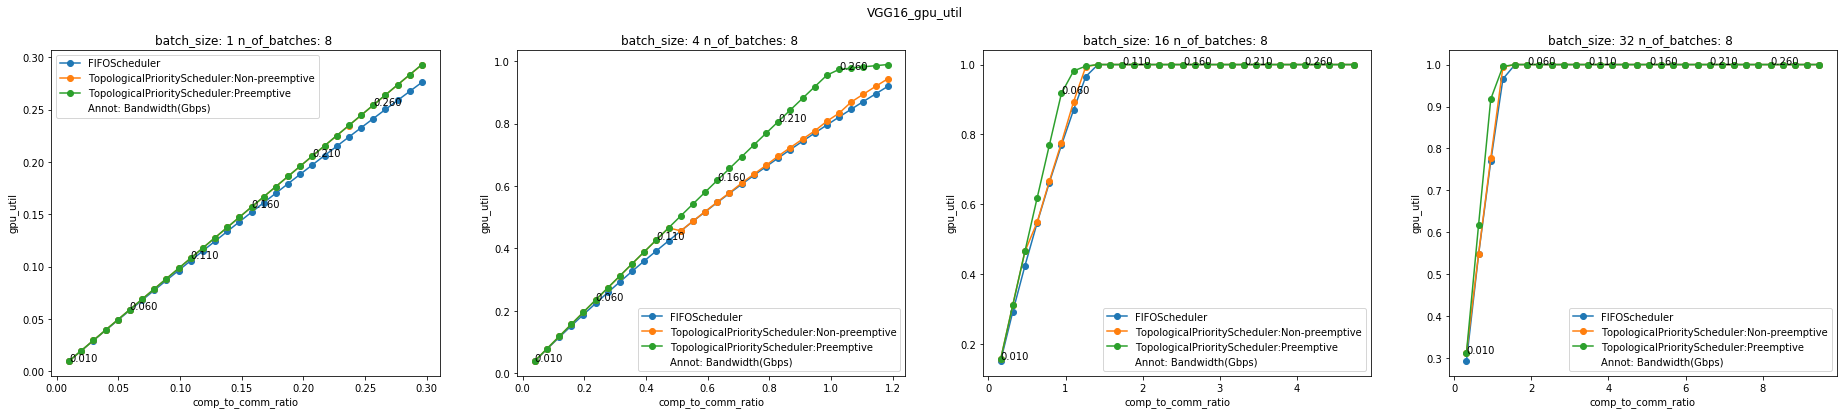

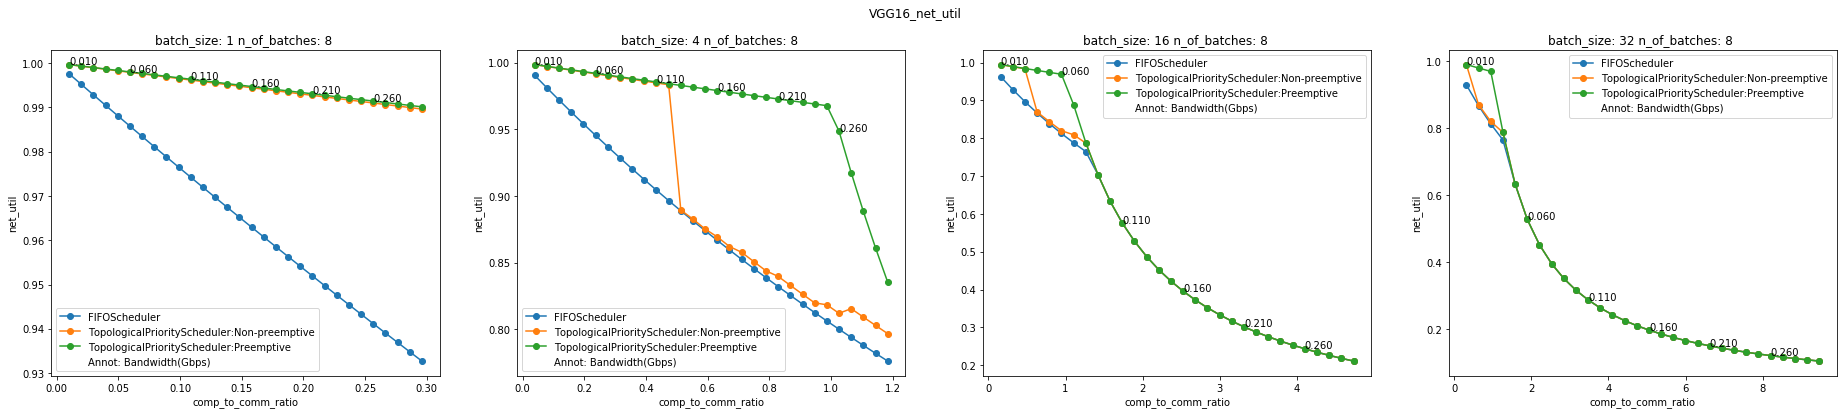

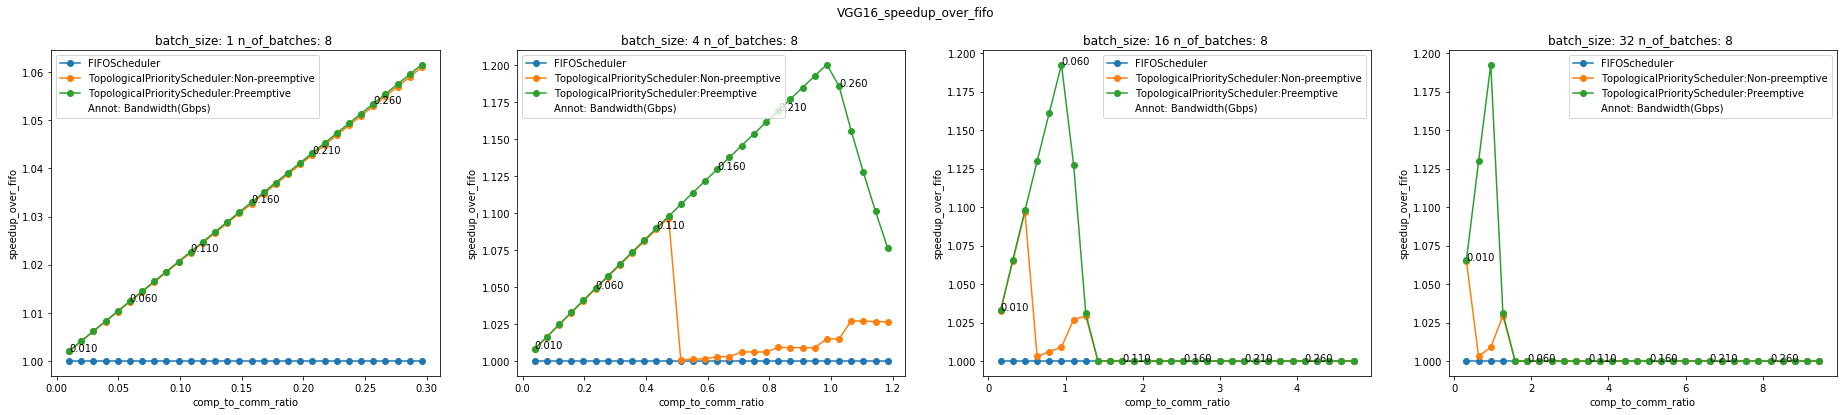

In [7]:
from matplotlib.backends.backend_pdf import PdfPages
file = PdfPages("{}_visualizaton.pdf".format("VGG16"))
for y in targets:
    f = line_plot_grid(summary["results"], title="{}_{}".format("VGG16", y), save=False,
                   x="comp_to_comm_ratio",
                   y=y,
                   line_variable="network_scheduler",
                   row_variable="batch_size",
                   column_variable="n_of_batches",
                   annotation_variable= "Bandwidth(Gbps)",
                   annotation_only_for_line_groups=["TopologicalPriorityScheduler:Preemptive"],
                   annotation_step=5,
                   label_length=float("inf"),
                   subplot_size=(8,6)
                  )
    file.savefig(f)

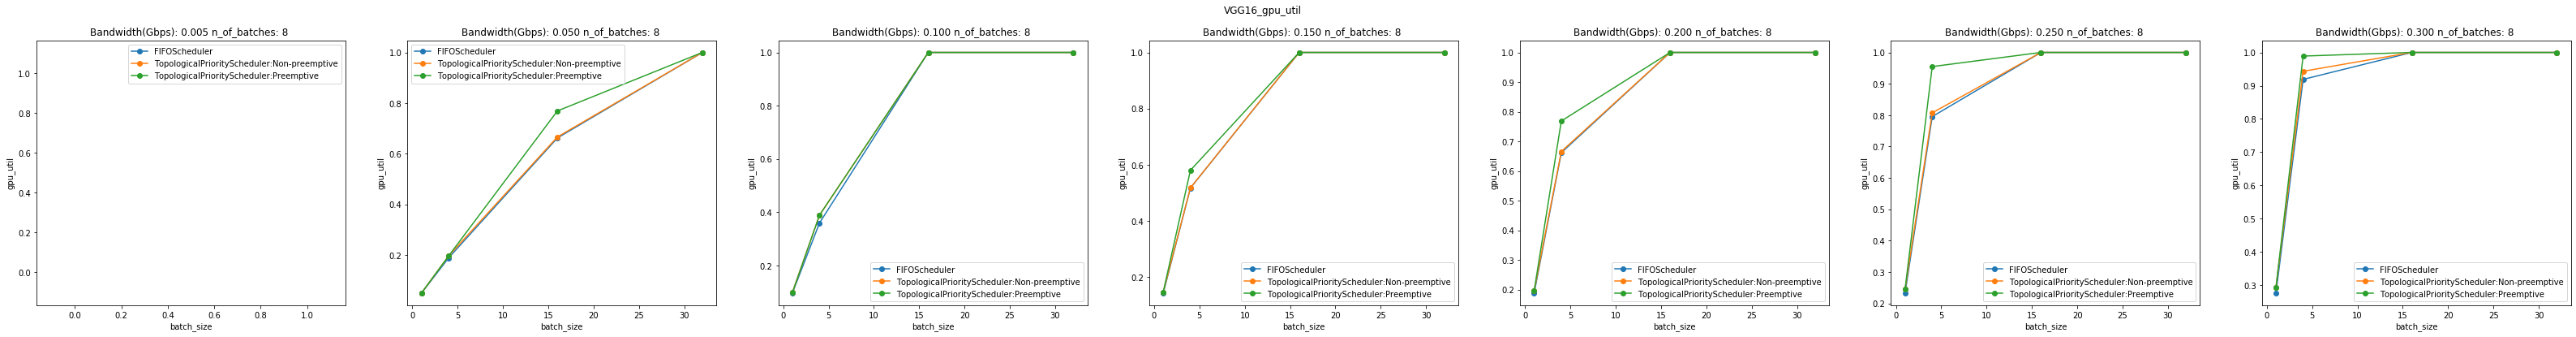

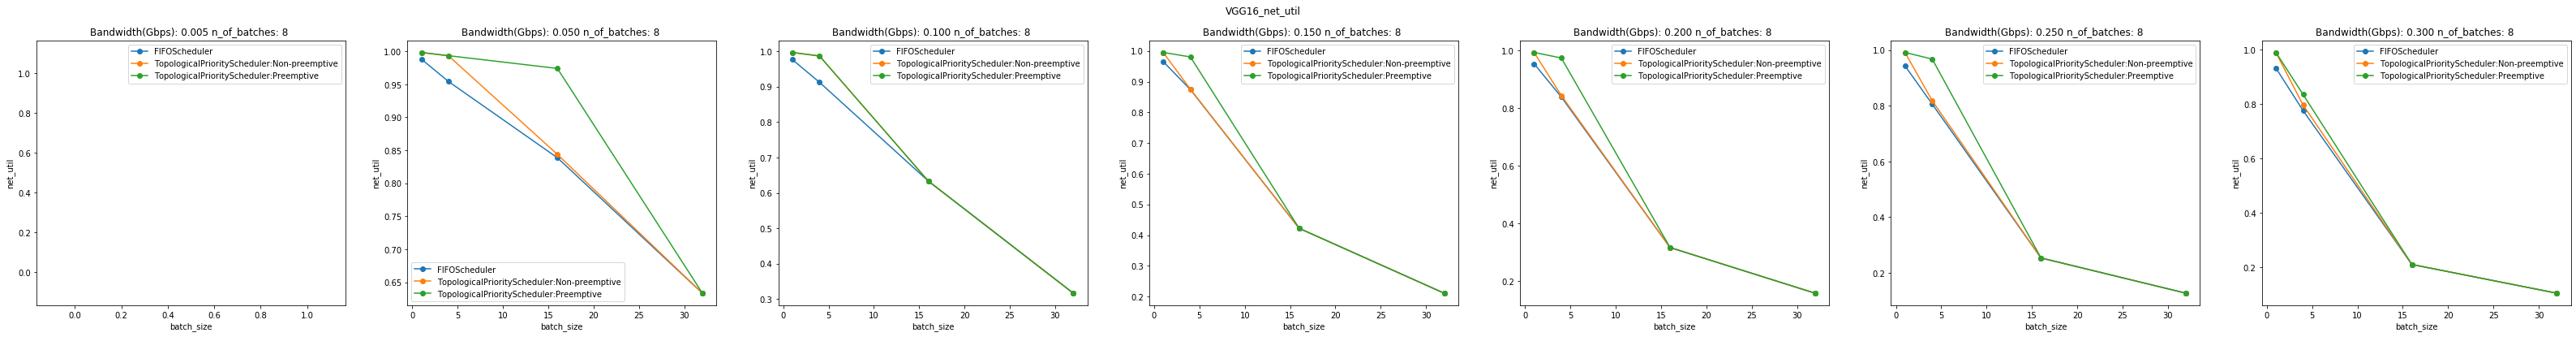

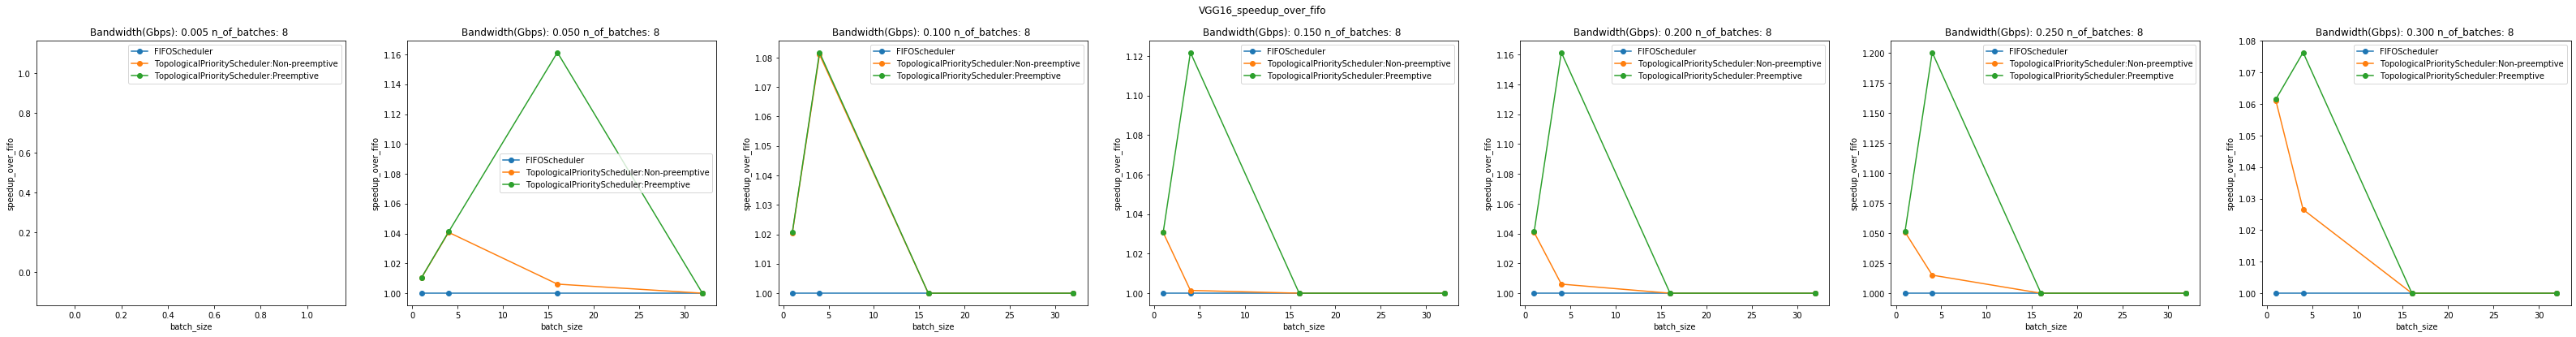

In [9]:
for y in targets:
    f = line_plot_grid(summary["results"], title="{}_{}".format("VGG16", y), save=False,
                   x="batch_size",
                   y=y,
                   line_variable=("network_scheduler"),
                   row_variable=("Bandwidth(Gbps)", ["0.005","0.050", "0.100","0.150", "0.200","0.250","0.300"]),
                   column_variable="n_of_batches",
                   label_length=float("inf"),
                   subplot_size=(8,6)
                )
    file.savefig(f)

In [10]:
file.close()